In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as colors
from mpl_toolkits import mplot3d
from math import sqrt
import warnings

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder, MinMaxScaler


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['savefig.dpi'] = 600
plt.rcParams["savefig.format"] = 'tiff'
warnings.filterwarnings("ignore")

In [2]:
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=2)


In [3]:
# Learning Rate Scheduler
def scheduler(epoch, lr):
  if epoch < 160:
    return lr
  else:
    return lr * np.exp(-0.1)

callback = keras.callbacks.LearningRateScheduler(scheduler)



# Neural Network
def Neural_network():
    init = keras.initializers.random_normal()
    model=Sequential()
    model.add(layers.Dense(64,activation='relu',kernel_initializer=init, input_dim=scaled_DF.shape[1]))
    model.add(layers.Dropout(0.1))
    

    model.add(layers.Dense(128,activation='relu',kernel_initializer=init))
    model.add(layers.Dropout(0.1))

    
    model.add(layers.Dense(128,activation='relu',kernel_initializer=init))
    model.add(layers.Dropout(0.1))

    
    model.add(layers.Dense(1,kernel_initializer=init,activation = 'linear'))
 
    
    optimize=tf.keras.optimizers.Adam()
    
    model.compile(optimizer=optimize,
                    loss='mse',
                    )
    return model

# To calclulate  Correlation and remove highly  correlated columns
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [4]:
# Funtion to train the model
def training_model(X_train,Y_train,model):
    history=model.fit(X_train,Y_train,epochs=200,batch_size=64,verbose=0,callbacks=[callback])
    return history

In [5]:
# To print losses
def plots():
    f, ax = plt.subplots(1,1)
    actual_test=np.array(scaler.inverse_transform(testY).reshape(-1,1))
    predicted_test=np.array(scaler.inverse_transform(model.predict(testX).reshape(-1,1)))

    #actual=testY
    #predicted= model.predict(testX)

    actual=np.array(scaler.inverse_transform(np.array(trainY).reshape(-1,1)))
    predicted=np.array(scaler.inverse_transform(model.predict(np.array(trainX)).reshape(-1,1)))

    sns.regplot(actual,predicted, color='midnightblue', scatter_kws={'alpha':0.5}, label='Train')
    plt.scatter(actual_test,predicted_test, color='crimson', alpha=0.5, label='Test') #linewidths=0.5, edgecolors='orange')
    
    
    print("Mean absolute error (MAE):      %f" % mean_absolute_error(actual_test,predicted_test))
    print("Mean squared error (MSE):       %f" % mean_squared_error(actual_test,predicted_test))
    print("Root mean squared error (RMSE): %f" % sqrt(mean_squared_error(actual_test,predicted_test)))
    print("R square (R^2):                 %f" % r2_score(actual_test,predicted_test))
    
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    #plt.suptitle("Actual Vs Predicted")
    anchored_text = AnchoredText("R\u00b2 Score_train  "+str(round(r2_score(actual,predicted),3))+'\n'"R\u00b2 Score_test  "+str(round(r2_score(actual_test,predicted_test),3)), loc=2,prop=dict(size=15))
    ax.add_artist(anchored_text)
    plt.savefig(str(model)[1:6], bbox_inches='tight')
    plt.legend(loc = 9, prop={'size': 15}) #labels=["Test","Train"], 
    plt.tight_layout()
    plt.show()

In [6]:
def defining_model(x):
    if x == 'mlr':
      model = LinearRegression()
    elif x=='adboost':
      model = AdaBoostRegressor()
    elif x=='xtratree':
      model = ExtraTreesRegressor()
    elif x=='bagging':
      model = BaggingRegressor()
    elif x=='pls':
      model = PLSRegression()
    elif x=='rndmfrst':
      model = RandomForestRegressor()
    elif x=='knn':
      model = KNeighborsRegressor()
    elif x=='svr':
      model = SVR()
    else:
      print("wrong selection")
    return model



In [7]:
# Getting data from CSV file
Train = pd.read_excel('train.xlsx')
Test = pd.read_excel('test.xlsx')
display(Train)
display(Test)

,Name of the Molecule,Solvent type,Smiles,N-Het,E(Energy),E(HOMO),E(LUMO),ꭓ(Electronegativity),µ(Chemical Potential),ɳ(Hardness),Ѡ(Electophilicity Index),d(Dipole Moment),H(Enthalpy),G(Gibbs Free Energy),Et(30)
0,4-cyano phenol,Alcohols/Phenols,OC1=CC=C(C#N)C=C1,2,-399.740103,-0.25520,-0.05525,0.155225,-0.155225,0.19995,0.002409,5.235618,-250767.03500,-250792.14200,52.2
1,methanol,Alcohols/Phenols,CO,1,-115.734970,-0.28244,-0.01342,0.147930,-0.147930,0.26902,0.002944,1.904125,-72588.87750,-72605.84570,55.4
2,5-nonanone,Ketones,O=C(CCCC)CCCC,1,-429.078984,-0.25181,-0.02364,0.137725,-0.137725,0.22817,0.002164,2.759200,-269078.53600,-269113.12370,37.5
3,propanenitrile,Nitrogen containing compounds,N#CCC,1,-172.083221,-0.33211,-0.02212,0.177115,-0.177115,0.30999,0.004862,4.181069,-107932.08400,-107952.38000,43.6
4,"2,4-dimethyl-3-pentanol",Alcohols/Phenols,CC(C)C(O)C(C)C,1,-351.641431,-0.27142,-0.01163,0.141525,-0.141525,0.25979,0.002602,1.495166,-220508.96300,-220537.94400,40.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2-hexanone,Ketones,CC(CCCC)=O,1,-311.126838,-0.25499,-0.02586,0.140425,-0.140425,0.22913,0.002259,2.969074,-195119.64850,-195148.04100,40.1
290,diethylene glycol diethyl ether,"Ethers,thioethers and acetals",CCOCCOCCOCC,3,-541.372052,-0.25577,-0.00703,0.131400,-0.131400,0.24874,0.002147,1.083249,-339538.82810,-339575.92340,37.5
291,diiodomethane,Halo-alkanes/alkenes/alkynes,IC(I)([H])[H],2,-62.056857,-0.26480,-0.08511,0.174955,-0.174955,0.17969,0.002750,1.395700,-38920.25327,-38942.40528,36.5
292,2-chloroethanol,Alcohols/Phenols,ClCCO,2,-614.651136,-0.29797,-0.02397,0.160970,-0.160970,0.27400,0.003550,2.079308,-385644.87900,-385666.64900,55.1


,Name of the Molecule,Solvent type,Smiles,N-Het,E(Energy),E(HOMO),E(LUMO),ꭓ(Electronegativity),µ(Chemical Potential),ɳ(Hardness),Ѡ(Electophilicity Index),d(Dipole Moment),H(Enthalpy),G(Gibbs Free Energy),Et(30)
0,"1,1-dichloroethene",Halo-alkanes/alkenes/alkynes,C=C(Cl)Cl,2,-997.784503,-0.27350,-0.03550,0.154500,-0.154500,0.23800,0.002841,1.492100,-626085.413,-625906.774,37.0
1,ethylammonium nitrate,Organic salts,[NH3+]CC.[O-][N+]([O-])=O,5,-416.119053,-0.29342,-0.06164,0.177530,-0.177530,0.23178,0.003652,6.402092,-261032.688,-261061.897,61.6
2,n-cyanomorpholine,Nitrogen containing compounds,N#CN1CCOCC1,3,-380.054315,-0.24731,-0.01579,0.131550,-0.131550,0.23152,0.002003,3.749573,-238395.349,-238420.226,42.8
3,4-chloro-3-methylphenol,Alcohols/Phenols,OC1=CC(C)=C(Cl)C=C1,2,-806.409087,-0.23093,-0.02612,0.128525,-0.128525,0.20481,0.001692,1.789384,-505939.034,-505965.767,51.0
4,1-chloropropane,Halo-alkanes/alkenes/alkynes,CCCCl,1,-578.754593,-0.29702,-0.01592,0.156470,-0.156470,0.28110,0.003441,2.419992,-363104.864,-363126.748,37.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,sulfolane,Sulphur compounds,O=S1(CCCC1)=O,3,-705.846273,-0.28799,-0.02245,0.155220,-0.155220,0.26554,0.003199,5.684700,-442836.836,-442860.992,44.1
123,ethylene sulfite,Sulphur compounds,O=S1OCCO1,4,-702.434818,-0.29853,-0.04377,0.171150,-0.171150,0.25476,0.003731,3.802498,-440730.263,-440735.068,45.3
124,trimethylacetonitrile,Nitrogen containing compounds,CC(C)(C)C#N,1,-250.719275,-0.32652,-0.01803,0.172275,-0.172275,0.30849,0.004578,4.209100,-157239.492,-157263.621,40.5
125,n-hexanenitrile,Nitrogen containing compounds,CCCCCC#N,1,-290.035969,-0.32495,-0.01836,0.171655,-0.171655,0.30659,0.004517,4.450374,-181891.431,-181918.549,41.4


In [8]:
# Combine Train and test for feature engineering
DF = pd.concat([Train,Test],ignore_index=True)
DF_data = DF.copy()
DF

,Name of the Molecule,Solvent type,Smiles,N-Het,E(Energy),E(HOMO),E(LUMO),ꭓ(Electronegativity),µ(Chemical Potential),ɳ(Hardness),Ѡ(Electophilicity Index),d(Dipole Moment),H(Enthalpy),G(Gibbs Free Energy),Et(30)
0,4-cyano phenol,Alcohols/Phenols,OC1=CC=C(C#N)C=C1,2,-399.740103,-0.25520,-0.05525,0.155225,-0.155225,0.19995,0.002409,5.235618,-250767.0350,-250792.1420,52.2
1,methanol,Alcohols/Phenols,CO,1,-115.734970,-0.28244,-0.01342,0.147930,-0.147930,0.26902,0.002944,1.904125,-72588.8775,-72605.8457,55.4
2,5-nonanone,Ketones,O=C(CCCC)CCCC,1,-429.078984,-0.25181,-0.02364,0.137725,-0.137725,0.22817,0.002164,2.759200,-269078.5360,-269113.1237,37.5
3,propanenitrile,Nitrogen containing compounds,N#CCC,1,-172.083221,-0.33211,-0.02212,0.177115,-0.177115,0.30999,0.004862,4.181069,-107932.0840,-107952.3800,43.6
4,"2,4-dimethyl-3-pentanol",Alcohols/Phenols,CC(C)C(O)C(C)C,1,-351.641431,-0.27142,-0.01163,0.141525,-0.141525,0.25979,0.002602,1.495166,-220508.9630,-220537.9440,40.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,sulfolane,Sulphur compounds,O=S1(CCCC1)=O,3,-705.846273,-0.28799,-0.02245,0.155220,-0.155220,0.26554,0.003199,5.684700,-442836.8360,-442860.9920,44.1
417,ethylene sulfite,Sulphur compounds,O=S1OCCO1,4,-702.434818,-0.29853,-0.04377,0.171150,-0.171150,0.25476,0.003731,3.802498,-440730.2630,-440735.0680,45.3
418,trimethylacetonitrile,Nitrogen containing compounds,CC(C)(C)C#N,1,-250.719275,-0.32652,-0.01803,0.172275,-0.172275,0.30849,0.004578,4.209100,-157239.4920,-157263.6210,40.5
419,n-hexanenitrile,Nitrogen containing compounds,CCCCCC#N,1,-290.035969,-0.32495,-0.01836,0.171655,-0.171655,0.30659,0.004517,4.450374,-181891.4310,-181918.5490,41.4


In [9]:
DF_data.columns

Index(['Name of the Molecule', 'Solvent type', 'Smiles', 'N-Het', 'E(Energy)',
       'E(HOMO)', 'E(LUMO)', 'ꭓ(Electronegativity)', 'µ(Chemical Potential)',
       'ɳ(Hardness)', 'Ѡ(Electophilicity Index)', 'd(Dipole Moment)',
       'H(Enthalpy)', 'G(Gibbs Free Energy)', 'Et(30)'],
      dtype='object')

In [10]:
# Removing Unwanted columns
DF_data=DF_data.drop(['Name of the Molecule','Smiles'],axis=1)
#DF_data

In [11]:
# Dropping highly correlated Features
corr_features = correlation(DF_data, 0.80)
print("No. of features to drop : ",len(set(corr_features)))

DF_data.drop(corr_features,axis=1,inplace=True)

No. of features to drop :  6


In [12]:
DF_data

,Solvent type,N-Het,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment),Et(30)
0,Alcohols/Phenols,2,-399.740103,-0.25520,-0.05525,5.235618,52.2
1,Alcohols/Phenols,1,-115.734970,-0.28244,-0.01342,1.904125,55.4
2,Ketones,1,-429.078984,-0.25181,-0.02364,2.759200,37.5
3,Nitrogen containing compounds,1,-172.083221,-0.33211,-0.02212,4.181069,43.6
4,Alcohols/Phenols,1,-351.641431,-0.27142,-0.01163,1.495166,40.1
...,...,...,...,...,...,...,...
416,Sulphur compounds,3,-705.846273,-0.28799,-0.02245,5.684700,44.1
417,Sulphur compounds,4,-702.434818,-0.29853,-0.04377,3.802498,45.3
418,Nitrogen containing compounds,1,-250.719275,-0.32652,-0.01803,4.209100,40.5
419,Nitrogen containing compounds,1,-290.035969,-0.32495,-0.01836,4.450374,41.4


In [13]:
DF_data.columns

Index(['Solvent type', 'N-Het', 'E(Energy)', 'E(HOMO)', 'E(LUMO)',
       'd(Dipole Moment)', 'Et(30)'],
      dtype='object')

In [14]:
DF_data

,Solvent type,N-Het,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment),Et(30)
0,Alcohols/Phenols,2,-399.740103,-0.25520,-0.05525,5.235618,52.2
1,Alcohols/Phenols,1,-115.734970,-0.28244,-0.01342,1.904125,55.4
2,Ketones,1,-429.078984,-0.25181,-0.02364,2.759200,37.5
3,Nitrogen containing compounds,1,-172.083221,-0.33211,-0.02212,4.181069,43.6
4,Alcohols/Phenols,1,-351.641431,-0.27142,-0.01163,1.495166,40.1
...,...,...,...,...,...,...,...
416,Sulphur compounds,3,-705.846273,-0.28799,-0.02245,5.684700,44.1
417,Sulphur compounds,4,-702.434818,-0.29853,-0.04377,3.802498,45.3
418,Nitrogen containing compounds,1,-250.719275,-0.32652,-0.01803,4.209100,40.5
419,Nitrogen containing compounds,1,-290.035969,-0.32495,-0.01836,4.450374,41.4


In [15]:

# Scaling the whole DataFrame



scaler = StandardScaler()
scaled_DF = pd.DataFrame(scaler.fit_transform(DF_data.iloc[:,2:6]))
scaled_DF.columns = DF_data.iloc[:,2:6].columns

scaled_DF['Et(30)'] = scaler.fit_transform(np.array(DF_data['Et(30)']).reshape(-1,1))
scaled_DF

display(scaled_DF)

,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment),Et(30)
0,0.326329,0.180203,-1.425164,1.230918,1.404655
1,0.650912,-0.642136,0.626336,-0.274361,1.852199
2,0.292798,0.282543,0.125109,0.111990,-0.651251
3,0.586513,-2.141607,0.199655,0.754438,0.201880
4,0.381300,-0.309457,0.714124,-0.459142,-0.287622
...,...,...,...,...,...
416,-0.023514,-0.809683,0.183471,1.433829,0.271809
417,-0.019615,-1.127872,-0.862142,0.583387,0.439638
418,0.496641,-1.972853,0.400244,0.767103,-0.231678
419,0.451707,-1.925456,0.384060,0.876119,-0.105807


In [16]:
DF_target = scaled_DF[['Et(30)']]
scaled_DF.drop('Et(30)',axis=1,inplace=True)

display(scaled_DF)
display(DF_target)

,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment)
0,0.326329,0.180203,-1.425164,1.230918
1,0.650912,-0.642136,0.626336,-0.274361
2,0.292798,0.282543,0.125109,0.111990
3,0.586513,-2.141607,0.199655,0.754438
4,0.381300,-0.309457,0.714124,-0.459142
...,...,...,...,...
416,-0.023514,-0.809683,0.183471,1.433829
417,-0.019615,-1.127872,-0.862142,0.583387
418,0.496641,-1.972853,0.400244,0.767103
419,0.451707,-1.925456,0.384060,0.876119


,Et(30)
0,1.404655
1,1.852199
2,-0.651251
3,0.201880
4,-0.287622
...,...
416,0.271809
417,0.439638
418,-0.231678
419,-0.105807


In [17]:
DF_data.columns.values

array(['Solvent type', 'N-Het', 'E(Energy)', 'E(HOMO)', 'E(LUMO)',
       'd(Dipole Moment)', 'Et(30)'], dtype=object)

In [18]:
scaled_DF[['N-Het']] = DF_data[['N-Het']]

In [19]:
scaled_DF

,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment),N-Het
0,0.326329,0.180203,-1.425164,1.230918,2
1,0.650912,-0.642136,0.626336,-0.274361,1
2,0.292798,0.282543,0.125109,0.111990,1
3,0.586513,-2.141607,0.199655,0.754438,1
4,0.381300,-0.309457,0.714124,-0.459142,1
...,...,...,...,...,...
416,-0.023514,-0.809683,0.183471,1.433829,3
417,-0.019615,-1.127872,-0.862142,0.583387,4
418,0.496641,-1.972853,0.400244,0.767103,1
419,0.451707,-1.925456,0.384060,0.876119,1


In [20]:
scaled_DF[['Solvent type']] = DF_data[['Solvent type']]


In [21]:
scaled_DF

,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment),N-Het,Solvent type
0,0.326329,0.180203,-1.425164,1.230918,2,Alcohols/Phenols
1,0.650912,-0.642136,0.626336,-0.274361,1,Alcohols/Phenols
2,0.292798,0.282543,0.125109,0.111990,1,Ketones
3,0.586513,-2.141607,0.199655,0.754438,1,Nitrogen containing compounds
4,0.381300,-0.309457,0.714124,-0.459142,1,Alcohols/Phenols
...,...,...,...,...,...,...
416,-0.023514,-0.809683,0.183471,1.433829,3,Sulphur compounds
417,-0.019615,-1.127872,-0.862142,0.583387,4,Sulphur compounds
418,0.496641,-1.972853,0.400244,0.767103,1,Nitrogen containing compounds
419,0.451707,-1.925456,0.384060,0.876119,1,Nitrogen containing compounds


In [22]:
scaled_DF = pd.get_dummies(scaled_DF)

In [23]:
scaled_DF

,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment),N-Het,Solvent type_Alcohols/Phenols,Solvent type_Alkanes and alkenes,Solvent type_Arenes,Solvent type_Carboxylic acids/anhydrides,Solvent type_Esters,"Solvent type_Ethers,thioethers and acetals",Solvent type_Halo-alkanes/alkenes/alkynes,Solvent type_Heteroarenes,Solvent type_Ketones,Solvent type_Nitrogen containing compounds,Solvent type_Organic salts,Solvent type_Phosphorous compounds,Solvent type_Sulphur compounds
0,0.326329,0.180203,-1.425164,1.230918,2,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0.650912,-0.642136,0.626336,-0.274361,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0.292798,0.282543,0.125109,0.111990,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.586513,-2.141607,0.199655,0.754438,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0.381300,-0.309457,0.714124,-0.459142,1,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,-0.023514,-0.809683,0.183471,1.433829,3,0,0,0,0,0,0,0,0,0,0,0,0,1
417,-0.019615,-1.127872,-0.862142,0.583387,4,0,0,0,0,0,0,0,0,0,0,0,0,1
418,0.496641,-1.972853,0.400244,0.767103,1,0,0,0,0,0,0,0,0,0,1,0,0,0
419,0.451707,-1.925456,0.384060,0.876119,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [24]:
scaled_DF.describe()

,E(Energy),E(HOMO),E(LUMO),d(Dipole Moment),N-Het,Solvent type_Alcohols/Phenols,Solvent type_Alkanes and alkenes,Solvent type_Arenes,Solvent type_Carboxylic acids/anhydrides,Solvent type_Esters,"Solvent type_Ethers,thioethers and acetals",Solvent type_Halo-alkanes/alkenes/alkynes,Solvent type_Heteroarenes,Solvent type_Ketones,Solvent type_Nitrogen containing compounds,Solvent type_Organic salts,Solvent type_Phosphorous compounds,Solvent type_Sulphur compounds
count,4.210000e+02,4.210000e+02,4.210000e+02,4.210000e+02,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,9.730933e-17,4.116528e-16,-1.182908e-16,-9.368331e-17,1.985748,0.247031,0.038005,0.068884,0.009501,0.085511,0.111639,0.102138,0.038005,0.042755,0.173397,0.042755,0.016627,0.023753
std,1.001190e+00,1.001190e+00,1.001190e+00,1.001190e+00,1.407391,0.431798,0.191435,0.253557,0.097125,0.279973,0.315296,0.303190,0.191435,0.202546,0.379040,0.202546,0.128022,0.152460
min,-8.078548e+00,-2.779192e+00,-4.456068e+00,-1.134708e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.707235e-02,-6.176831e-01,-3.334504e-01,-5.183396e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.402768e-01,7.424118e-02,4.174094e-01,-2.844933e-01,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.333975e-01,6.695618e-01,6.773412e-01,2.782646e-01,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.122600e-01,3.431523e+00,1.626338e+00,5.828362e+00,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
trainX = scaled_DF[:len(Train)] 
testX = scaled_DF[len(Train):]

trainY = DF_target[:len(Train)]
testY = DF_target[len(Train):]

Average validation R2 score after crossvalidation :  0.6446997249842538
Average validation rmse score after crossvalidation :  4.2063700175077265


Training Accuracy :  0.7125206920728404
Mean absolute error (MAE):      2.735571
Mean squared error (MSE):       13.555722
Root mean squared error (RMSE): 3.681810
R square (R^2):                 0.719305


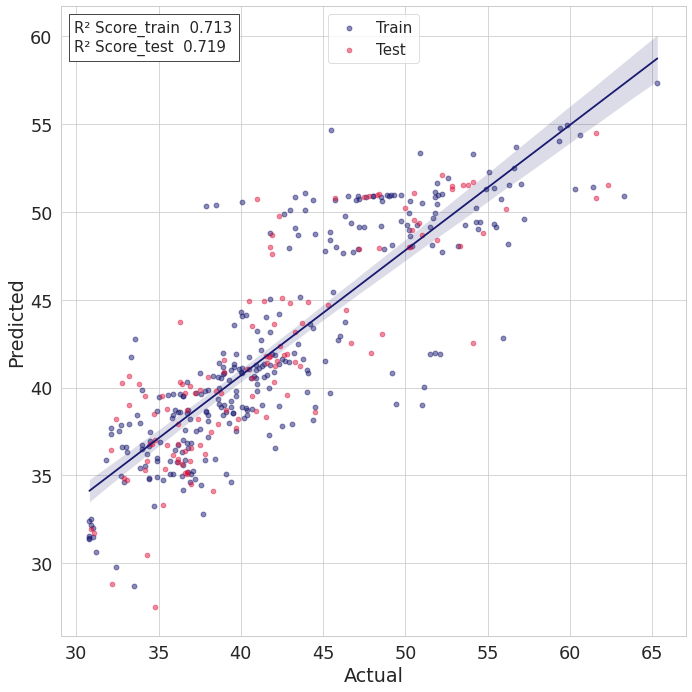

In [26]:
# Multiple Linear Regression
model = defining_model(x = 'mlr')

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted))))
# Unscaled

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data
model = defining_model(x = 'mlr')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.6249624698408056
Average validation rmse score after crossvalidation :  4.40903028323469


Training Accuracy :  0.7706633094380045
Mean absolute error (MAE):      2.397323
Mean squared error (MSE):       12.938630
Root mean squared error (RMSE): 3.597031
R square (R^2):                 0.732083


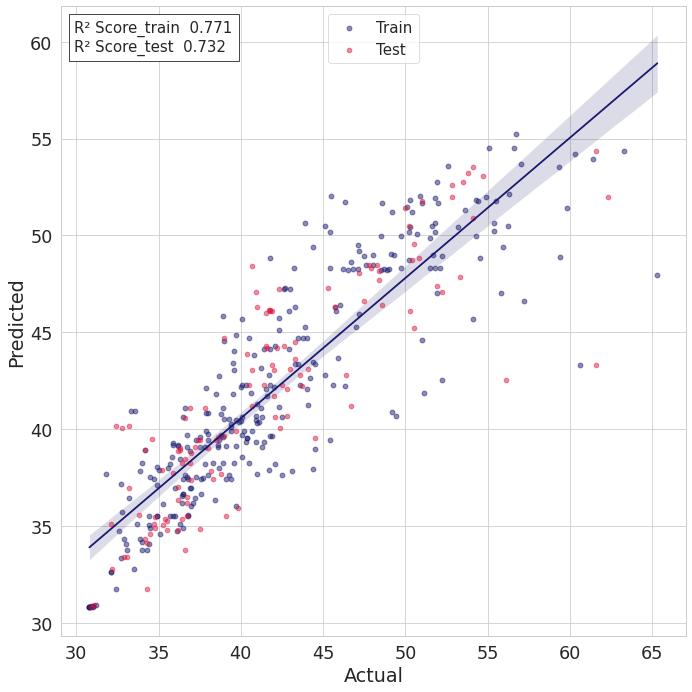

In [27]:
# KNN
model = defining_model(x = 'knn')

kfold = KFold(n_splits=5, shuffle=False)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted))))
# Unscaled

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data
model = defining_model(x = 'knn')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.6803065554897205
Average validation rmse score after crossvalidation :  4.061352388874764


Training Accuracy :  0.7640589906633626
Mean absolute error (MAE):      2.103503
Mean squared error (MSE):       10.128238
Root mean squared error (RMSE): 3.182489
R square (R^2):                 0.790277


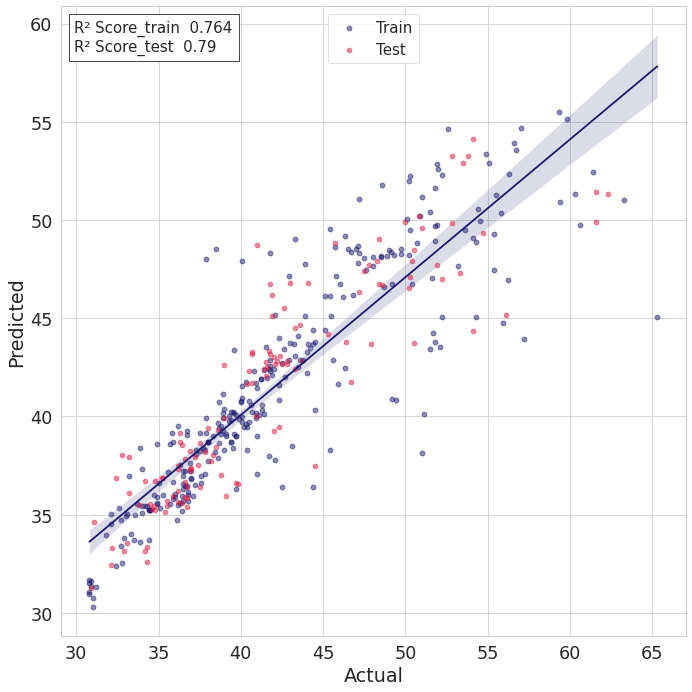

In [28]:
# Support Vector Regressor
model = defining_model(x = 'svr')

kfold = KFold(n_splits=5, shuffle=False)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted.reshape(-1,1)))))
# Unscaled

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data
model = defining_model(x = 'svr')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.6379373584667473
Average validation rmse score after crossvalidation :  4.2986982058294325


Training Accuracy :  0.7720750611354675
Mean absolute error (MAE):      3.481397
Mean squared error (MSE):       15.022696
Root mean squared error (RMSE): 3.875912
R square (R^2):                 0.688928


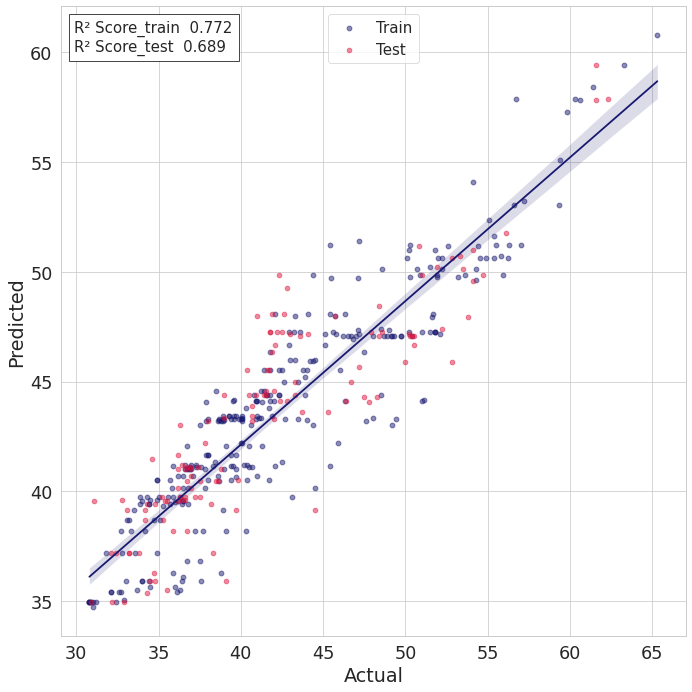

In [29]:
#Adaboost
model = defining_model(x = 'adboost')
kfold = KFold(n_splits=5, shuffle=False)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted.reshape(-1,1)))))

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))


# Train model on whole train data
model = defining_model(x = 'adboost')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.803228981411773
Average validation rmse score after crossvalidation :  3.1088130331667823


Training Accuracy :  1.0
Mean absolute error (MAE):      1.393205
Mean squared error (MSE):       4.045109
Root mean squared error (RMSE): 2.011246
R square (R^2):                 0.916239


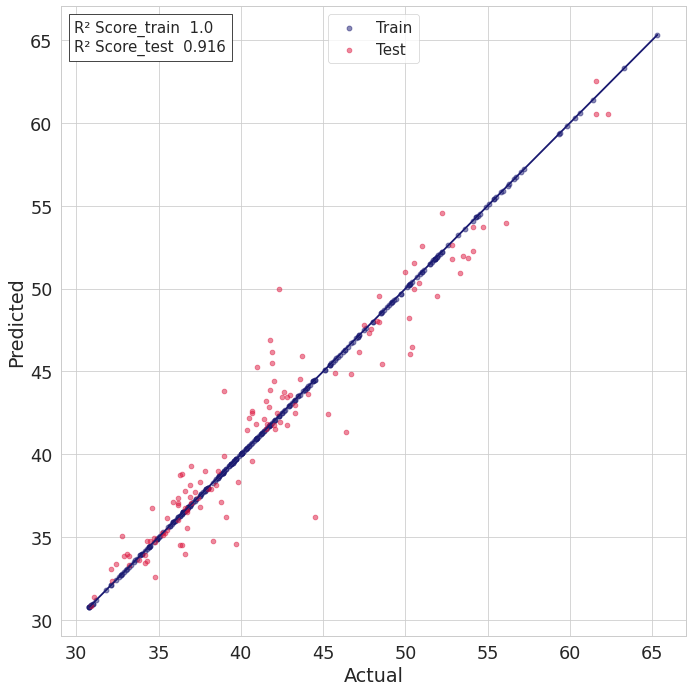

In [30]:
# Extra Tree Regressor
model = defining_model(x = 'xtratree')
kfold = KFold(n_splits=5, shuffle=True)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted.reshape(-1,1)))))

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))


# Train model on whole train data
model = defining_model(x = 'xtratree')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.7331294378030984
Average validation rmse score after crossvalidation :  3.6083789066621925


Training Accuracy :  0.9619475847657525
Mean absolute error (MAE):      1.803150
Mean squared error (MSE):       5.930216
Root mean squared error (RMSE): 2.435203
R square (R^2):                 0.877204


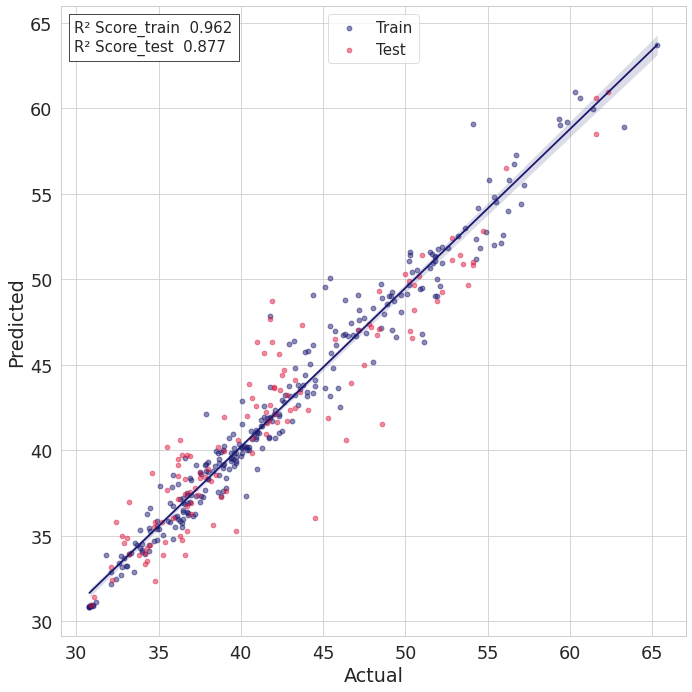

In [31]:
# Bagging Regressor
model = defining_model(x = 'bagging')
kfold = KFold(n_splits=5, shuffle=False)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted.reshape(-1,1)))))

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data
model = defining_model(x = 'bagging')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.7493815264916422
Average validation rmse score after crossvalidation :  3.5176968374280633


Training Accuracy :  0.9682208803786658
Mean absolute error (MAE):      1.804567
Mean squared error (MSE):       6.045946
Root mean squared error (RMSE): 2.458851
R square (R^2):                 0.874808


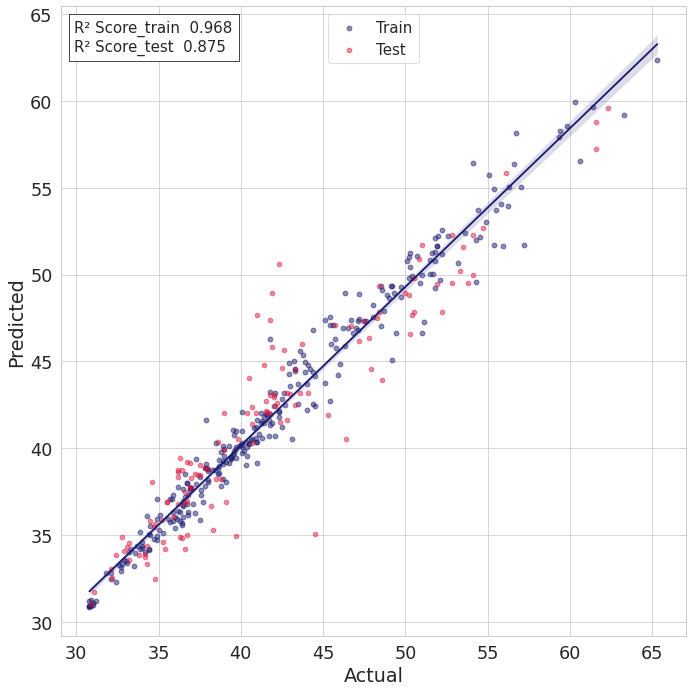

In [32]:
# Random Forest
model = defining_model(x = 'rndmfrst')
kfold = KFold(n_splits=5, shuffle=False)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted.reshape(-1,1)))))

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))


# Train model on whole train data
model = defining_model(x = 'rndmfrst')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.6450453608054548
Average validation rmse score after crossvalidation :  4.20249963484393


Training Accuracy :  0.6968990080070308
Mean absolute error (MAE):      2.645546
Mean squared error (MSE):       14.330148
Root mean squared error (RMSE): 3.785518
R square (R^2):                 0.703269


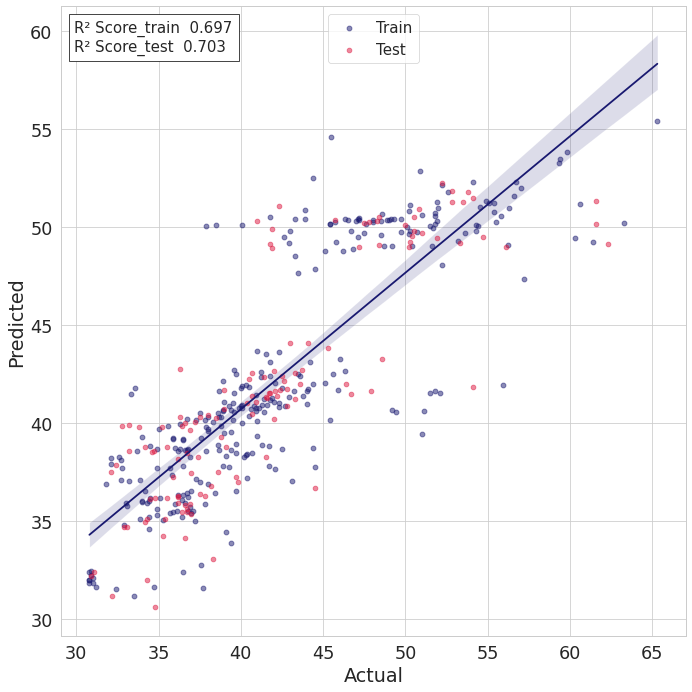

In [33]:
# Partial Least Square
model = defining_model(x = 'pls')

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted))))
# Unscaled

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data
model = defining_model(x = 'pls')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

2022-05-18 18:35:55.920338: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-18 18:35:55.920515: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-18 18:35:55.921003: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-18 18:35:56.009217: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-18 18:35:56.029418: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Average validation R2 score after crossvalidation :  0.9242748365193085
Average validation rmse score after crossvalidation :  1.9627785449074864


Training Accuracy :  0.9471046423621677
Mean absolute error (MAE):      1.523398
Mean squared error (MSE):       4.305313
Root mean squared error (RMSE): 2.074925
R square (R^2):                 0.910851


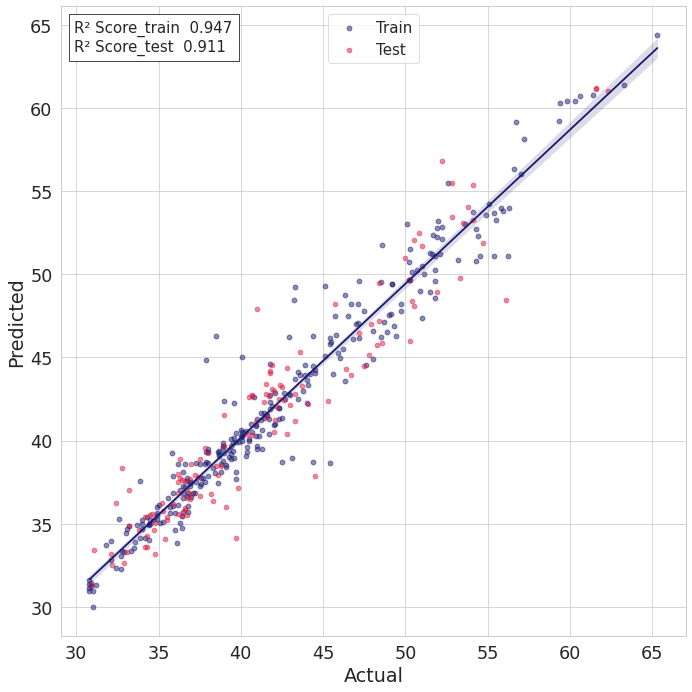

In [34]:
model = Neural_network()

kfold = KFold(n_splits=5, shuffle=True, random_state=1500)

best_score = 0.1

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  training_model(trainX.iloc[train],trainY.iloc[train],model)
  scores.append(r2_score(trainY.iloc[valid],model.predict(trainX.iloc[valid])))
  
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted))))
    
print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data

model = Neural_network()
training_model(trainX,trainY,model)
#actual = trainY
#predicted = model.predict(trainX)

actual=np.array(scaler.inverse_transform(np.array(trainY)))
predicted=np.array(scaler.inverse_transform(model.predict(np.array(trainX)).reshape(-1,1)))
model.save("nn.h5")
score = r2_score(actual,predicted)
print("\n\nTraining Accuracy : ",score) # Training Accuracy
plots()

In [35]:
actual_test=np.array(scaler.inverse_transform(testY).reshape(-1,1))
predicted_test=np.array(scaler.inverse_transform(model.predict(testX).reshape(-1,1)))

In [36]:
predictions_DF = Test[['Name of the Molecule','Solvent type']]
predictions_DF['Actual'] = np.squeeze(actual_test)
predictions_DF['Predicted'] = np.squeeze(predicted_test)

In [37]:
predictions_DF.to_excel('predictions.xlsx',index = False)

In [38]:
predictions_DF = Train[['Name of the Molecule','Solvent type']]
predictions_DF['Actual'] = np.squeeze(actual)
predictions_DF['Predicted'] = np.squeeze(predicted)

In [39]:
predictions_DF.to_excel('predictions_train.xlsx',index = False)